In [1]:
import os
import cv2
import keras
import numpy as np
import tensorflow as tf
from keras.utils.np_utils import to_categorical
from keras.models import load_model  
from keras.utils import plot_model
from keras import Sequential
from keras.layers import Conv2D,MaxPooling2D,Flatten,Softmax,Activation,Dense,Dropout
from keras.callbacks import Callback,ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score,auc
#from skimage.transform import rescale, resize
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.preprocessing import StandardScaler
import pickle
from skimage import measure
from skimage import morphology
from skimage.transform import resize
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
dataset = keras.preprocessing.image_dataset_from_directory(
  '/content/drive/MyDrive/COVID19_CT_Scans/dataset', batch_size=512, image_size=(200, 200), validation_split = 0.2,subset="training",seed=1337)


Found 13689 files belonging to 2 classes.
Using 10952 files for training.


In [4]:
valset = keras.preprocessing.image_dataset_from_directory(
  '/content/drive/MyDrive/COVID19_CT_Scans/test', batch_size=64, image_size=(200, 200), validation_split = 0.2, subset="validation",seed=1337)


Found 300 files belonging to 2 classes.
Using 60 files for validation.


In [5]:
for data, labels in valset:
   print(data.shape)    # (10, 200, 200, 3)
   print(data.dtype)    # float32
   print(labels.shape)  # (10,)
   print(labels.dtype)
   print(labels) 

(60, 200, 200, 3)
<dtype: 'float32'>
(60,)
<dtype: 'int32'>
tf.Tensor(
[1 1 0 1 1 0 0 0 1 0 0 0 0 0 1 1 0 1 0 1 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 0 1
 0 0 0 1 0 1 1 1 1 0 1 1 0 1 1 1 0 1 1 1 0 0 1], shape=(60,), dtype=int32)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


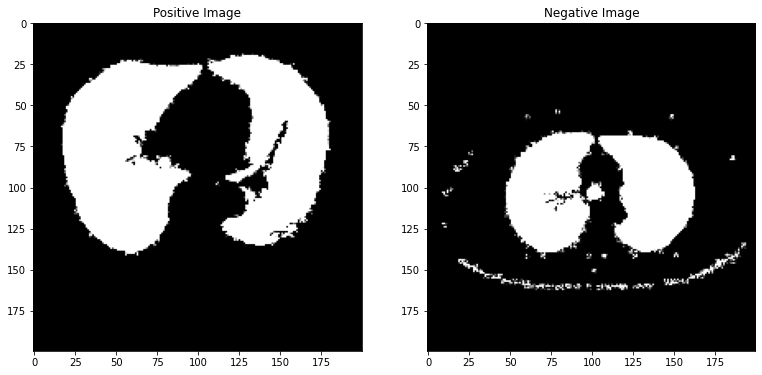

In [6]:
fig= plt.figure(figsize=(20,10))

a= fig.add_subplot(1,3,2)
a.set_title('Positive Image')
plt.imshow(data[3])

a= fig.add_subplot(1,3,3)
a.set_title("Negative Image")
plt.imshow(data[2])

In [5]:
#Not using all augmentation approches due to the presences of huge volume of images 
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.2),
        # layers.experimental.preprocessing.RandomContrast(factor = [0,1],seed = 22),
        # layers.experimental.preprocessing.RandomTranslation(height_factor= 0.3,width_factor=0.2 ),
        # layers.experimental.preprocessing.RandomZoom(height_factor=(0.1, 0.3)),
    ]
)


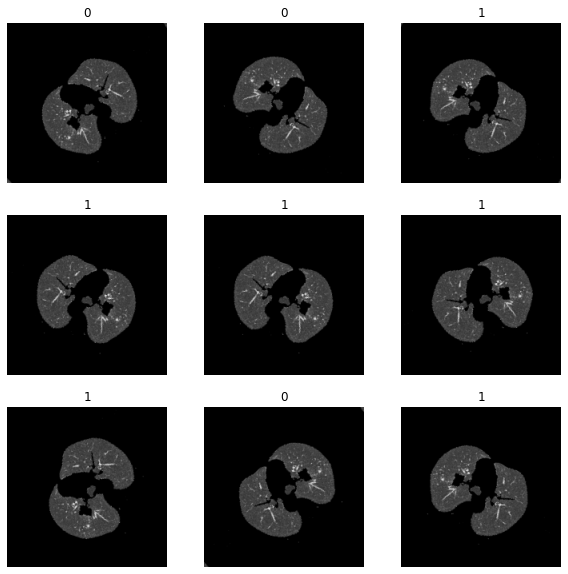

In [6]:
for images, labels in dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(
            tf.expand_dims(first_image, 0), training=True
        )
        plt.imshow(augmented_image[0].numpy().astype("int32"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [7]:
dataset = dataset.prefetch(buffer_size=256)
valset = valset.prefetch(buffer_size=256)

base_model = keras.applications.Xception(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(200, 200, 3),
    include_top=False,
)  # Do not include the ImageNet classifier at the top.

# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(200, 200, 3))
x = data_augmentation(inputs)  # Apply random data augmentation

#Normalization
norm_layer = keras.layers.experimental.preprocessing.Normalization()
mean = np.array([127.5] * 3)
var = mean ** 2
# Scale inputs to [-1, +1]
x = norm_layer(x)
norm_layer.set_weights([mean, var])

x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(1, activation = "sigmoid")(x)
model = keras.Model(inputs, outputs)

model.summary()


Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 200, 200, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 200, 200, 3)       0         
_________________________________________________________________
normalization (Normalization (None, 200, 200, 3)       7         
_________________________________________________________________
xception (Functional)        (None, 7, 7, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                

In [8]:
# Train the top layer
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 20
model.fit(dataset, epochs=epochs, validation_data = valset, class_weight = {0:1 , 1:3})


Epoch 1/20
22/22 [==============================] - 42s 2s/step - loss: 1.0395 - binary_accuracy: 0.7100 - val_loss: 0.6159 - val_binary_accuracy: 0.7833
Epoch 2/20
22/22 [==============================] - 41s 2s/step - loss: 0.9590 - binary_accuracy: 0.8152 - val_loss: 0.6049 - val_binary_accuracy: 0.7667
Epoch 3/20
22/22 [==============================] - 40s 2s/step - loss: 0.9329 - binary_accuracy: 0.8426 - val_loss: 0.6053 - val_binary_accuracy: 0.7667
Epoch 4/20
22/22 [==============================] - 40s 2s/step - loss: 0.9146 - binary_accuracy: 0.8631 - val_loss: 0.6031 - val_binary_accuracy: 0.7500
Epoch 5/20
22/22 [==============================] - 43s 2s/step - loss: 0.9048 - binary_accuracy: 0.8776 - val_loss: 0.6016 - val_binary_accuracy: 0.7667
Epoch 6/20
22/22 [==============================] - 46s 2s/step - loss: 0.8950 - binary_accuracy: 0.8838 - val_loss: 0.6008 - val_binary_accuracy: 0.7500
Epoch 7/20
22/22 [==============================] - 45s 2s/step - loss: 0.88

In [8]:
# Unfreeze the base_model and fine-tuning of the entire model
base_model.trainable = True
model.summary()

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate (1e-5)
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)


Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 200, 200, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 200, 200, 3)       0         
_________________________________________________________________
normalization (Normalization (None, 200, 200, 3)       7         
_________________________________________________________________
xception (Functional)        (None, 7, 7, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                

In [ ]:
# ResourceExhaustedError, unable to execute due to memory issues and GPU limitations
epochs = 10
model.fit(dataset, epochs=epochs, validation_data=valset, class_weight = {0:1 , 1:3})

In [18]:
#inference on new data
img = keras.preprocessing.image.load_img(
    "/content/drive/MyDrive/COVID19_CT_Scans/test/pCT_test/pCT4000.jpg", target_size=(200,200)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
print(
    "This CT scan is %.2f percent Covid negative and %.2f percent Covid positive."
    % (100 * (1 - score), 100 * score)
)


This CT scan is 10.35 percent Covid negative and 89.65 percent Covid positive.


In [19]:
model.save(filepath = '/content/drive/MyDrive/COVID19_CT_Scans/Xception_model_Full.h5')